In [27]:
from datetime import datetime
import pandas as pd
from geopy.distance import distance
import numpy as np
import random

import pymongo
from pymongo import MongoClient



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from sklearn.model_selection import cross_validate




import pymongo
from pymongo import MongoClient

import matplotlib.pyplot as plt

plt.style.use("ggplot")

%matplotlib inline

In [28]:
client = MongoClient('localhost', 27017)

db = client['avl_pipeline_test']

trip_coll = db['clean_trips']
chnk_coll = db['chunk_info']

In [29]:
trip_coll.find_one()

{'_id': ObjectId('5ae4dcb33ad39e1721401dad'),
 'HEADING': '82.0',
 'LATITUDE': '37.78693',
 'LONGITUDE': '-122.4565',
 'PREDICTABLE': '1',
 'REPORT_TIME': '10/28/2016 00:27:57',
 'REV': '1526',
 'SPEED': '0.0',
 'TRAIN_ASSIGNMENT': '3305',
 'VEHICLE_TAG': '5419',
 'minutes_noon_sqr': 480249,
 'sched_time_diff_seconds': 123,
 'service_id': 1,
 'time_stamp': 1477639677.0,
 'trip_id': 7253717,
 'trip_id_iso': '7253717_2016-10-28_JRMFT',
 'trip_start': 1,
 'chunk_2': '1',
 'chunk_6': '1',
 'chunk_12': '1'}

In [30]:
six_cnk_info = chnk_coll.find_one({'number_chunks':6})

In [31]:
all_trips = trip_coll.distinct('trip_id_iso')
# # Testing
# all_trips = all_trips[33:34]

In [37]:
trip_list = []

for trip in all_trips:
    
    trip_data = {}
    
    breakin = 0
    
    for chnk_seq, chnk_data in six_cnk_info['chunks'].items():
        
        if chnk_seq in ['1','2', '3']:
        
            search = {
                'trip_id_iso': trip,
                'chunk_6': chnk_seq
            }

            chnk_str = '_chnk_' + chnk_seq

            chnk_cursor = trip_coll.find(search)
            
            if chnk_cursor.count() == 0:
                continue

            chnk_df = pd.DataFrame(list(chnk_cursor))

            min_ts = chnk_df['time_stamp'].min()
            max_ts = chnk_df['time_stamp'].max()
            chnk_secs = max_ts - min_ts
            
            if chnk_secs > 2500:
                breakin += 1
                break

            trip_data['seconds' + chnk_str ] = chnk_secs

            min_dt = datetime.fromtimestamp(min_ts)
            mfn_sq = (((min_dt.hour * 60) + min_dt.minute) - 720)**2

            mfn_abs = abs(((min_dt.hour * 60) + min_dt.minute) - 720)
        
            trip_data['mfn_sq' + chnk_str] = mfn_sq
            trip_data['mfn_abs' + chnk_str] = mfn_abs
            
            avg_spd = chnk_df['SPEED'].astype('float').mean()

            trip_data['avg_speed' + chnk_str] = avg_spd
        
    
    if breakin == 0:
    
        trip_list.append(trip_data)

In [38]:
chnky_df = pd.DataFrame(trip_list)

In [52]:
chnky_df = chnky_df.dropna()

In [54]:
chnky_df.mean()

avg_speed_chnk_1             5.212797
avg_speed_chnk_2             5.333654
avg_speed_chnk_3             5.676692
chnk1_mfn_abs_chnk_1       292.667925
chnk1_mfn_abs_chnk_2       294.511698
chnk1_mfn_abs_chnk_3       296.801509
chnk1_mfn_sq_chnk_1     124639.798491
chnk1_mfn_sq_chnk_2     126523.470189
chnk1_mfn_sq_chnk_3     128583.806792
seconds_chnk_1             499.183396
seconds_chnk_2             467.242264
seconds_chnk_3             443.842264
dtype: float64

In [55]:
y = chnky_df['seconds_chnk_3'].values
y = y.reshape(-1,1)

In [60]:
# X = chnky_df[['chnk1_mfn_sq_chnk_1', 'seconds_chnk_1']].values

X = chnky_df[['seconds_chnk_2', 'chnk1_mfn_abs_chnk_2']].values
# X = X.reshape(-1,1)


In [61]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

# X_norm = X
# y_norm = y

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

In [62]:
# fit with statsmodels
model1 = sm.OLS(y_train,X_train)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     52.23
Date:                Fri, 04 May 2018   Prob (F-statistic):           2.72e-22
Time:                        13:24:04   Log-Likelihood:                -1375.8
No. Observations:                 993   AIC:                             2756.
Df Residuals:                     991   BIC:                             2765.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2134      0.033      6.533      0.000       0.149       0.277
x2            -0.1698      0.033     -5.164      0.000      -0.234      -0.105
==============================================================================
Omnibus:                      388.122   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7871.391
Skew:                           1.278   Prob(JB):                         0.00
Kurtosis:                      16.554   Cond. No.                         1.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
regr = RandomForestRegressor(n_estimators=50)

crossed = cross_validate(regr, X_norm, y_norm.flatten(), cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

rmse_norm = (abs(crossed['test_neg_mean_squared_error'].mean()))**.5
r2 = crossed['test_neg_mean_squared_error'].mean()

print ("R-squared: ", r2)
print ('RMSE: ', scaler_y.inverse_transform([rmse_norm])[0])

R-squared:  -0.9742037246446124
RMSE:  530.5401597908635


In [64]:
x = chnky_df['seconds_chnk_3'].values
y = chnky_df['seconds_chnk_2'].values

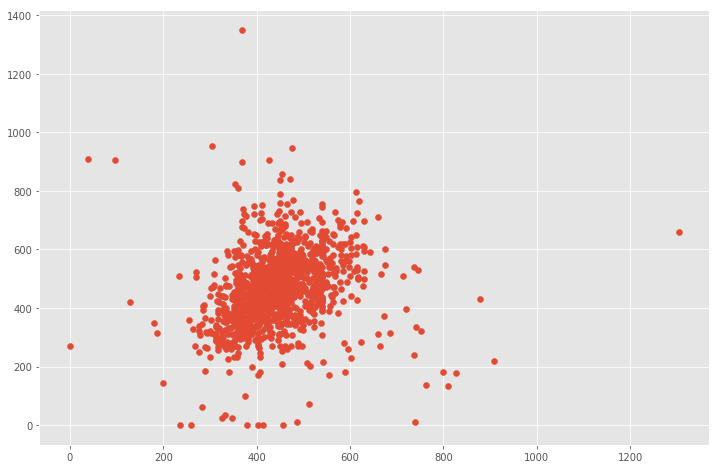

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);